# Regression on polynomial features dataset

In [ ]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polynomial_featextract import poly_featextract

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import raw data and params.txt file
datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"

rawdata = load_data(datadir_path)
params = load_params(datadir_path)
ker_integrals = load_wlist(datadir_path) # load wlist.txt file

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading rawdata into numpy array
Finsihed loading parameters file
finished loading kernel-integrals file.


In [ ]:
print(rawdata.shape)
offset = 150
shifted_data, center = get_window(rawdata,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

(10500, 943)
The Echo pulse occurs at timestep: 628


In [ ]:
pd.options.mode.chained_assignment = None

y_classes = params[['αx','αz','ξ']]
y_classes['len_scale'] = np.sqrt(ker_integrals.values.flatten()/(params['αx'].values+1))
y_classes.head()

,αx,αz,ξ,len_scale
0,0.000140,0.004113,2.038144,0.230070
1,0.000288,0.005442,1.698081,0.220174
2,0.000948,0.000869,2.757263,0.251400
3,0.008380,0.014527,1.236614,0.343557
4,0.000710,0.013350,1.144264,0.214364


In [ ]:
polyfeats = poly_featextract(rscl_data, [4,5,10], [3,3,3], as_df=True)
polyfeats.head()

,4_1_0,4_1_1,4_1_2,4_1_3,4_2_0,4_2_1,4_2_2,4_2_3,4_3_0,4_3_1,4_3_2,4_3_3,4_4_0,4_4_1,4_4_2,4_4_3,5_1_0,5_1_1,5_1_2,5_1_3,5_2_0,5_2_1,5_2_2,5_2_3,5_3_0,5_3_1,5_3_2,5_3_3,5_4_0,5_4_1,5_4_2,5_4_3,5_5_0,5_5_1,5_5_2,5_5_3,10_1_0,10_1_1,10_1_2,10_1_3,10_2_0,10_2_1,10_2_2,10_2_3,10_3_0,10_3_1,10_3_2,10_3_3,10_4_0,10_4_1,10_4_2,10_4_3,10_5_0,10_5_1,10_5_2,10_5_3,10_6_0,10_6_1,10_6_2,10_6_3,10_7_0,10_7_1,10_7_2,10_7_3,10_8_0,10_8_1,10_8_2,10_8_3,10_9_0,10_9_1,10_9_2,10_9_3,10_10_0,10_10_1,10_10_2,10_10_3
0,2.236470e-07,0.000006,0.000135,0.011056,0.000004,0.000259,0.007989,0.151059,-0.000004,0.000274,-0.008279,0.146295,-2.149142e-07,6.155184e-06,-0.000127,0.010173,4.935042e-08,-9.564643e-07,0.000146,0.010836,0.000001,0.000088,0.002330,0.050902,-1.240648e-06,-0.000796,0.000025,0.788313,-0.000002,0.000088,-0.002004,0.043527,-1.111921e-07,-9.397075e-07,-0.000102,0.009810,-0.000004,3.937068e-07,0.000778,0.007660,2.546437e-08,0.000025,0.000113,0.011351,0.000003,0.000015,0.000244,0.031908,0.000005,0.000144,0.005397,0.110987,0.000009,0.000671,0.025493,0.506981,4.404496e-08,0.000656,-0.026719,0.493492,-0.000005,0.000145,-0.005154,0.099619,-3.561492e-06,0.000002,-0.000040,0.029204,0.000001,0.000023,-0.000220,0.010351,0.000003,-4.742971e-07,-0.000630,0.007237
1,2.215008e-07,0.000007,0.000148,0.011400,0.000004,0.000257,0.008087,0.155030,-0.000004,0.000277,-0.008140,0.139200,-2.150578e-07,5.847759e-06,-0.000100,0.009622,5.348174e-08,-7.629906e-07,0.000151,0.011101,0.000001,0.000088,0.002405,0.052983,-8.409482e-07,-0.000797,-0.000491,0.787621,-0.000002,0.000088,-0.001867,0.039771,-8.054796e-08,-1.246002e-06,-0.000098,0.009474,-0.000004,3.085515e-06,0.000780,0.007683,6.577907e-08,0.000028,0.000119,0.011560,0.000003,0.000017,0.000310,0.033036,0.000005,0.000144,0.005447,0.114158,0.000009,0.000658,0.025438,0.512003,-4.031941e-07,0.000675,-0.026876,0.485822,-0.000005,0.000146,-0.005067,0.093880,-3.919389e-06,-0.000003,0.000076,0.027217,0.000001,0.000016,-0.000196,0.010274,0.000003,-7.368338e-06,-0.000562,0.007548
2,3.011159e-07,0.000003,0.000062,0.015478,0.000004,0.000259,0.007630,0.150626,-0.000006,0.000335,-0.006469,0.054775,1.576197e-07,-4.457967e-07,-0.000172,0.005378,1.130315e-07,-6.060068e-06,0.000133,0.015633,0.000001,0.000084,0.002449,0.053891,6.345070e-07,-0.000842,-0.003147,0.763734,-0.000003,0.000060,0.000137,0.004831,2.699844e-07,3.462030e-06,-0.000216,0.004133,-0.000005,-7.924675e-06,0.001086,0.011249,5.534691e-07,0.000026,-0.000077,0.014808,0.000004,0.000024,0.000249,0.032969,0.000005,0.000132,0.005112,0.113869,0.000010,0.000707,0.025671,0.501332,-2.417505e-06,0.000851,-0.029530,0.405186,-0.000002,0.000219,-0.003503,0.021530,5.906802e-07,0.000006,-0.000393,0.007274,0.000003,-0.000022,-0.000514,0.008249,0.000002,-2.192775e-07,-0.000209,0.003928
3,3.582810e-06,-0.000153,0.003142,0.558517,-0.000004,0.000325,0.012640,0.249613,-0.000021,-0.000052,0.015769,0.671904,-1.123982e-05,-7.467074e-05,0.011848,0.386328,1.741358e-05,-2.428894e-04,-0.003017,0.518130,0.000002,0.000552,-0.010246,0.174025,5.025033e-06,-0.000381,-0.002618,0.771057,0.000023,-0.000455,-0.021611,0.691974,-1.166589e-05,-3.644715e-04,0.008965,0.474250,-0.000018,-1.136943e-04,0.019888,0.354187,6.979802e-05,0.002911,-0.011550,0.323371,-0.000007,0.000789,-0.020678,0.440769,-0.000007,0.000016,0.012085,0.181037,-0.000208,0.000602,0.045921,0.610748,-9.352133e-05,0.001560,0.001255,0.527728,-0.000060,-0.001001,0.023720,0.813619,-1.219899e-04,0.000352,0.002809,0.339447,0.000053,-0.000710,-0.002286,0.344669,-0.000009,-9.708226e-04,-0.012851,0.510316
4,1.944124e-07,0.000007,0.000210,0.012615,0.000004,0.000254,0.008289,0.162810,-0.000004,0.000285,-0.007789,0.123668,-2.987454e-07,4.270846e-06,0.000077,0.008701,2.661306e-08,1.556227e-07,0.000202,0.011918,0.000001,0.000090,0.002508,0.057282,3.756669e-08,-0.000801,-0.001610,0.785572,-0.000002,0.000084,-0.001624,0.031687,-1.269993e-07,-4.705512e-06,0.000014,0.009837,-0.000004,1.038819e-05,0.000740,0.007664,-2.213830e-07,0.000031,0.000210,0.012940,0.

In [ ]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
def plots_transform(df, var, transformer):
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    sns.kdeplot(df[var])
    plt.title('before ' + str(transformer).split('(')[0])
    
    plt.subplot(122)
    p1 = transformer.fit_transform(df[[var]]).flatten()
    sns.kdeplot(p1)
    plt.title('after ' + str(transformer).split('(')[0])

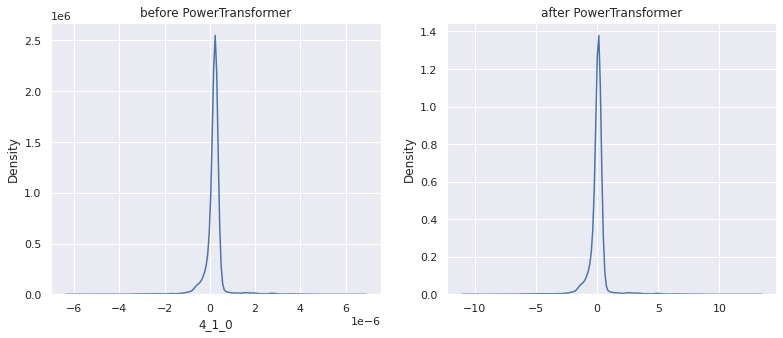

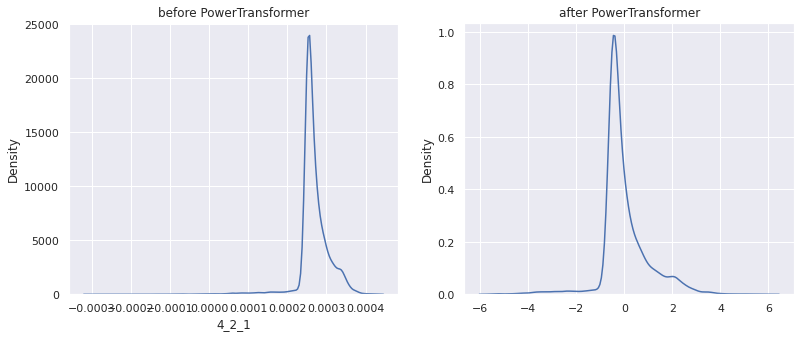

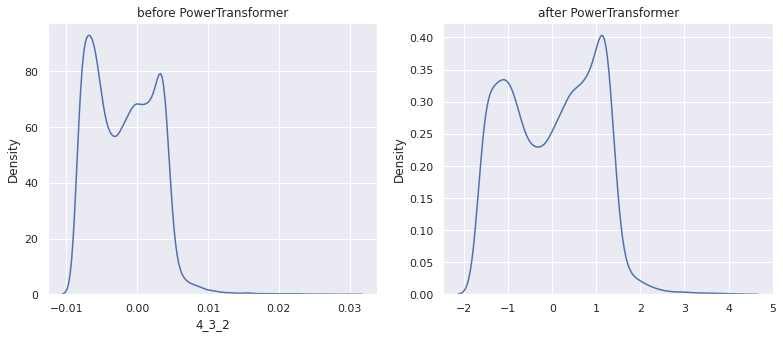

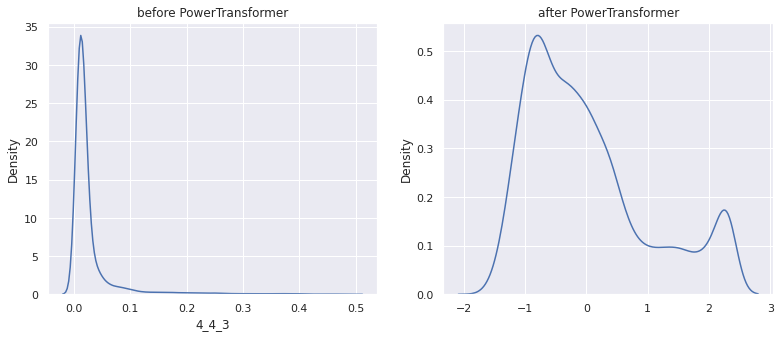

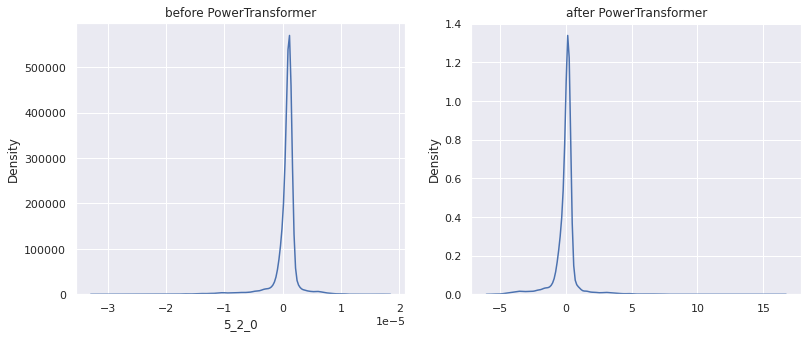

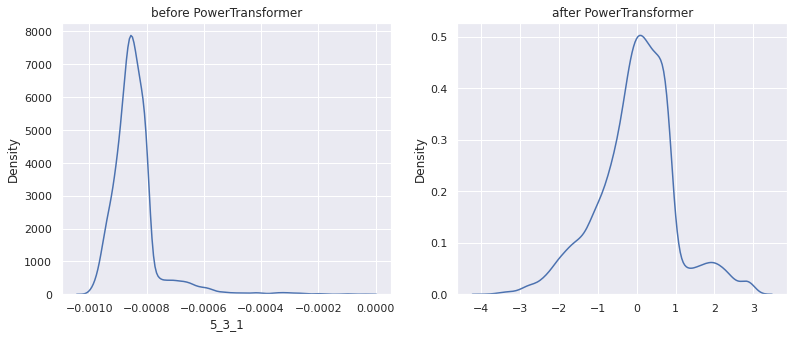

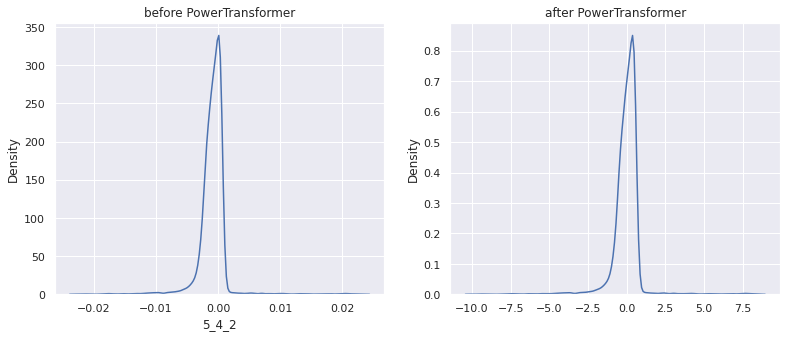

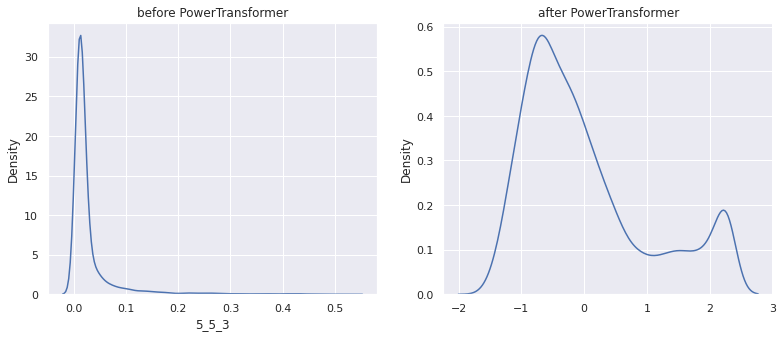

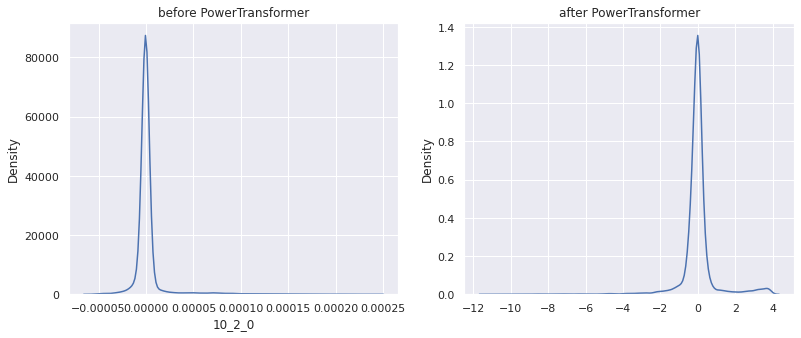

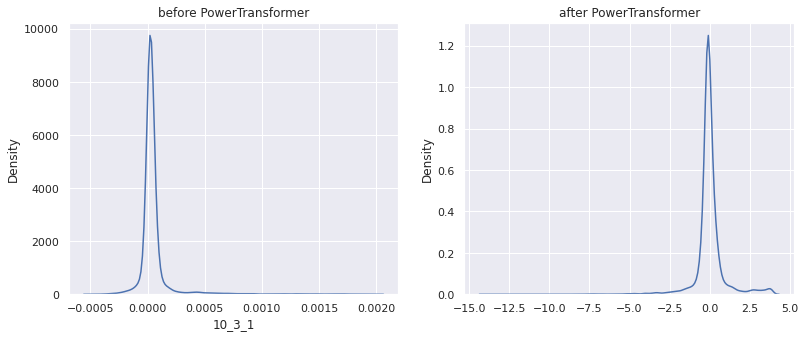

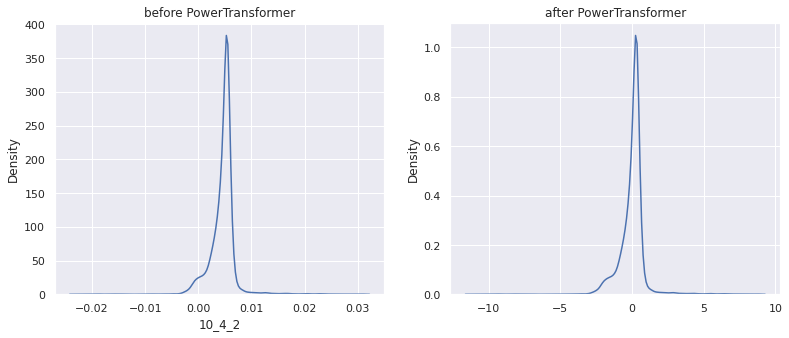

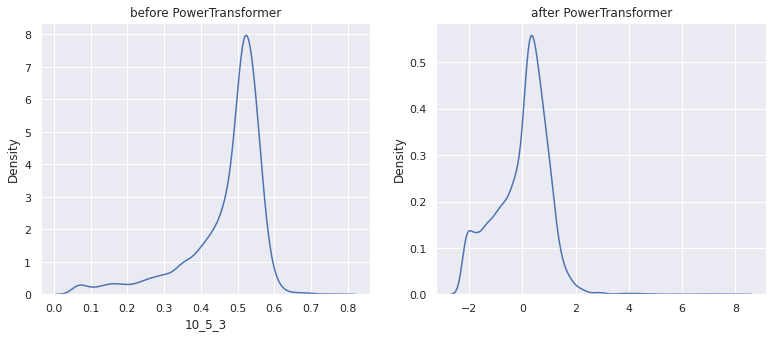

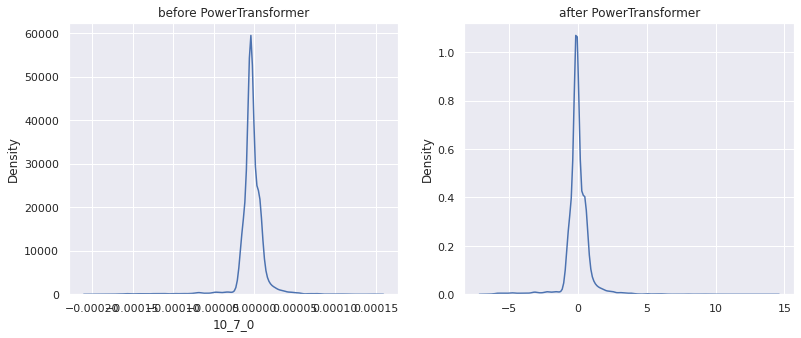

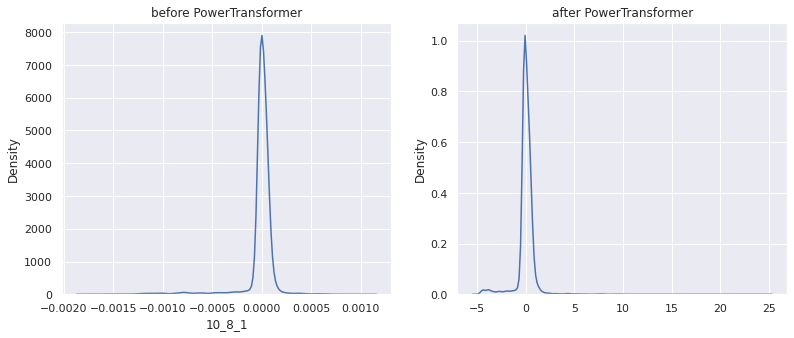

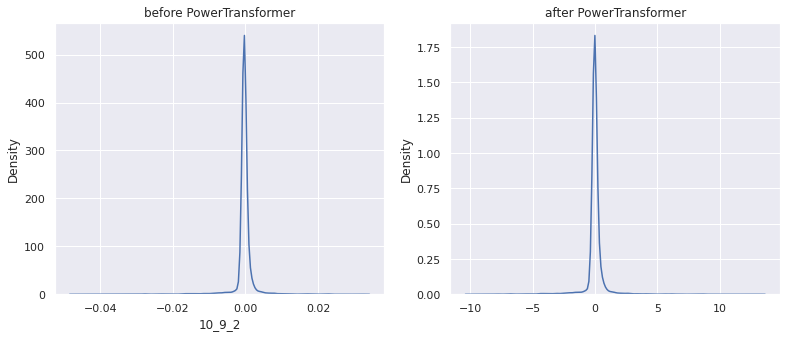

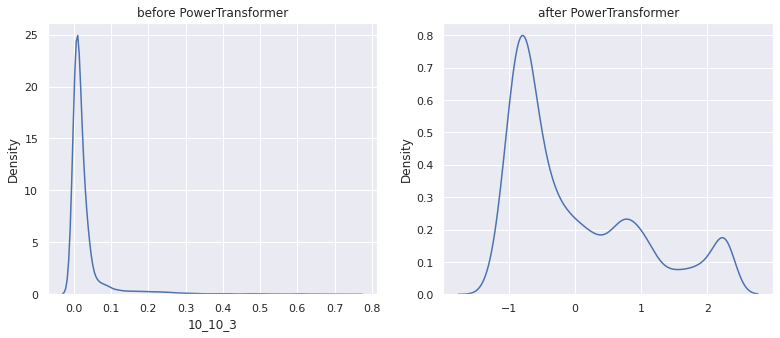

In [ ]:
for col_no in range(0, polyfeats.shape[1], 5):
    col = polyfeats.columns[col_no]
    plots_transform(polyfeats, col, PowerTransformer(method='yeo-johnson'))

# Regression before classification

In [224]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

In [160]:
X_train, X_test, y_train, y_test = train_test_split(polyfeats,
                                                    y_classes, 
                                                    stratify=params['stencil_type'],
                                                    test_size=0.2, random_state=1)

## Mutual Information based feature selection

In [ ]:
# feature selection
def select_features(X_train, y_train, X_test):
	"""configure to select all features, learn relationship from training data,
    transform train input data, transform test input data"""

	fs = SelectKBest(score_func=mutual_info_regression, k='all')
	fs.fit(X_train, y_train)
	#X_train_fs = fs.transform(X_train)
	#X_test_fs = fs.transform(X_test)
	return fs

In [ ]:
MI = pd.DataFrame(polyfeats.columns.tolist(),columns=['Feature'])

for col in y_classes.columns :
    fs = select_features(X_train, y_train[col], X_test)
    MI[f"MI-{col}"] = fs.scores_

In [ ]:
MI.head()

,Feature,MI-αx,MI-αz,MI-ξ,MI-len_scale
0,4_1_0,0.242586,0.232042,0.241170,0.266072
1,4_1_1,0.367208,0.243036,0.269485,0.314435
2,4_1_2,0.444428,0.189227,0.237080,0.301648
3,4_1_3,0.283161,0.125629,0.233207,0.361009
4,4_2_0,0.393310,0.277227,0.171431,0.222897


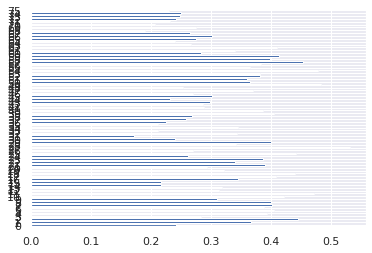

In [ ]:
MI['MI-αx'].plot.barh()

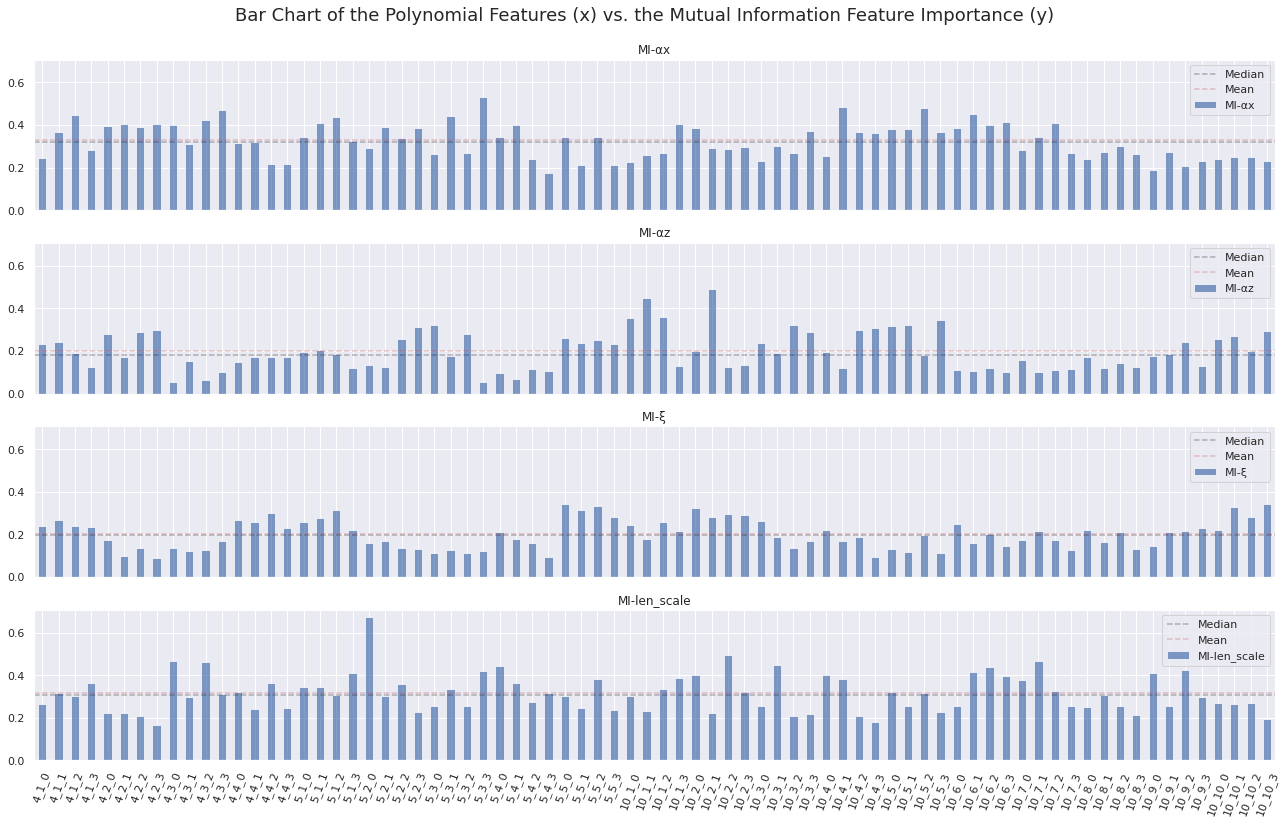

In [ ]:
fig, axes = plt.subplots(4,1,sharey=True,sharex=True,figsize=(18,12))

for col,ax in zip(MI.columns[1:],axes):
    MI[col].plot.bar(ax=ax, alpha=0.7)
    ax.set(title=f"{col}")
    ax.axhline(y=MI[col].median(),color='k',ls='--',alpha=0.3,label='Median')
    ax.axhline(y=MI[col].mean(),color='r',ls='--',alpha=0.3,label='Mean')
    ax.legend()

plt.xticks(np.arange(76),MI['Feature'].values.tolist(),rotation=70)

plt.suptitle("Bar Chart of the Polynomial Features (x) vs. the Mutual Information Feature Importance (y)", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
feats_mean = []
for num_col in MI.select_dtypes(include=np.number).columns.tolist():
    df_new = MI[['Feature',num_col]][MI[num_col] > MI[num_col].mean()]
    feats_mean.append(df_new)
    print(num_col, df_new.shape)

MI-αx (37, 2)
MI-αz (31, 2)
MI-ξ (37, 2)
MI-len_scale (32, 2)


## Feature selection based on RF feature importance

### $\alpha _x$ prediction

In [222]:
rf = RandomForestRegressor(n_estimators=40, oob_score=True, n_jobs=-1)

In [225]:
?cross_val_score

In [226]:
### Base model
results = list()

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(rf, rscl_data, y_classes['αx'],
                         scoring='neg_mean_absolute_error', cv=cv,
                         verbose=1, n_jobs=-1)
results.append(scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 12.5min finished


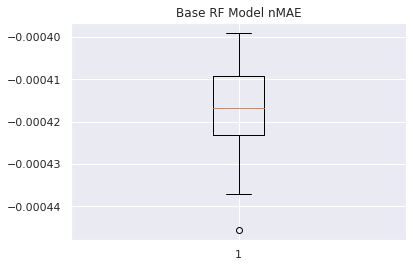

In [248]:
plt.title("Base RF Model nMAE")
plt.boxplot(results)
plt.show()

In [241]:
feat_ax = MI[['Feature','MI-αx']].sort_values("MI-αx",ascending=False)
feat_ax


,Feature,MI-αx
27,5_3_3,0.531005
49,10_4_1,0.482826
54,10_5_2,0.478542
11,4_3_3,0.471071
57,10_6_1,0.453425
...,...,...
33,5_5_1,0.212271
35,5_5_3,0.211842
70,10_9_2,0.206708
68,10_9_0,0.189839


In [243]:
feat_axlist = feat_ax['Feature'].tolist()

In [244]:
from sklearn.tree import DecisionTreeRegressor

In [257]:
dt = DecisionTreeRegressor()
base_dt_results = []
dt_scores = cross_val_score(dt, polyfeats, y_classes['αx'],
                         scoring='neg_mean_absolute_error', cv=cv,
                         verbose=1, n_jobs=-1)
base_dt_results.append(dt_scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    8.8s finished


[array([-0.00060824, -0.00051265, -0.00055963, -0.00057972, -0.00055768,
       -0.00058953, -0.00059566, -0.00057988, -0.0005825 , -0.00058737,
       -0.00062718, -0.0005432 , -0.00058699, -0.00054662, -0.00058487])]


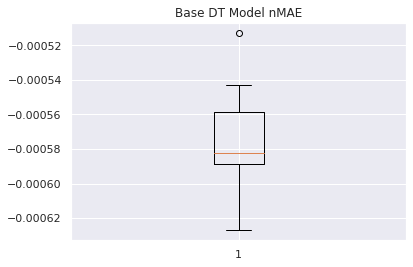

In [258]:
print(base_dt_results)

plt.title("Base DT Model nMAE")
plt.boxplot(base_dt_results)
plt.show()



In [272]:
dt_results = []

for i in range(len(feat_axlist)//3, len(feat_axlist), 2):
    dt = DecisionTreeRegressor()
    dt_scores_feats = cross_val_score(dt, polyfeats[feat_axlist[:i]], y_classes['αx'],
                         scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    dt_results.append(dt_scores_feats)
    print(f"{i} features, Mean_score:{np.mean(dt_scores_feats)}, std_dev:{np.std(dt_scores_feats)}")

25 features, Mean_score:-0.0006861678152760827, std_dev:2.2336623031187602e-05
27 features, Mean_score:-0.0006721700360202854, std_dev:2.9405653613787084e-05
29 features, Mean_score:-0.0006679193720536069, std_dev:3.2519708802690496e-05
31 features, Mean_score:-0.0006672949264707503, std_dev:2.8773391463695166e-05
33 features, Mean_score:-0.0006523394458435434, std_dev:3.16086457230201e-05
35 features, Mean_score:-0.0006507981066484567, std_dev:2.4715646906955643e-05
37 features, Mean_score:-0.0006621702544291118, std_dev:2.4634920094203682e-05
39 features, Mean_score:-0.0006470175128269664, std_dev:2.0426888248912893e-05
41 features, Mean_score:-0.0006444787091416636, std_dev:1.764248734165541e-05
43 features, Mean_score:-0.000649628336541427, std_dev:1.8918248891963023e-05
45 features, Mean_score:-0.0006332682225598632, std_dev:2.3295118095594982e-05
47 features, Mean_score:-0.0006145400524182247, std_dev:1.8930129956266455e-05
49 features, Mean_score:-0.0006092664612008087, std_dev:

{'boxes': [<matplotlib.lines.Line2D at 0x7f23dfd3cf90>],
 'caps': [<matplotlib.lines.Line2D at 0x7f23dfd446d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f23de104cd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f23e09cac10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f23dffe9a10>,
  <matplotlib.lines.Line2D at 0x7f23df59ad50>]}

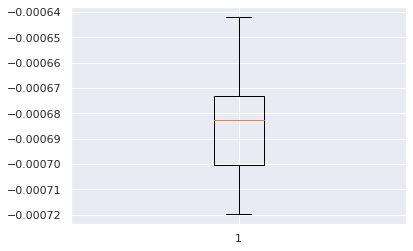

In [284]:
plt.boxplot(dt_results[0])

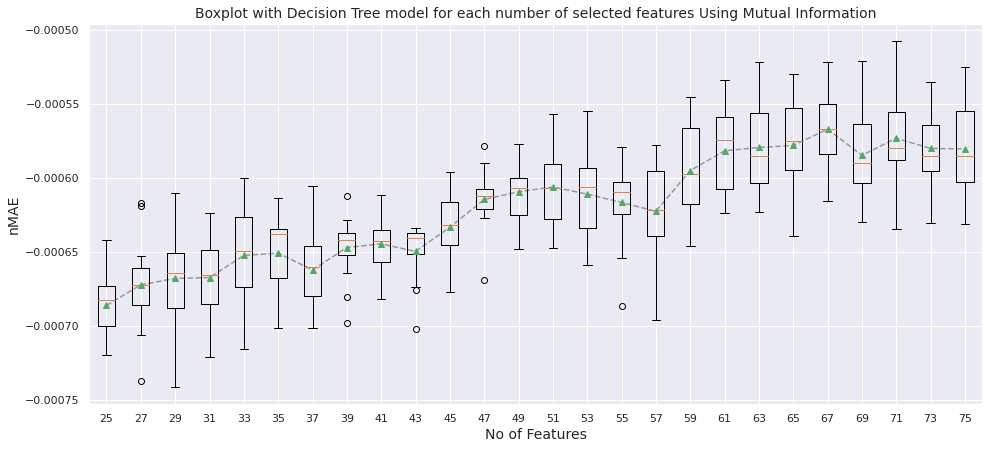

In [293]:
# plot model performance for comparison
plt.figure(figsize=(16,7))
plt.boxplot(dt_results, showmeans=True)
plt.plot(np.arange(1,27),[np.mean(i) for i in dt_results],'k--', alpha=0.4)
plt.xticks(np.arange(1,27), range(len(feat_axlist)//3, len(feat_axlist), 2))
plt.xlabel("No of Features", fontsize=14)
plt.ylabel("nMAE", fontsize=14)
plt.title("Boxplot with Decision Tree model for each number of selected features Using Mutual Information", fontsize=14)
plt.show()

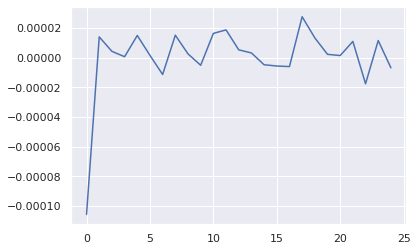

In [297]:
# Per feature increase in nMAE

mae_values = [np.mean(i) for i in dt_results]
plt.plot([mae_values[j] - mae_values[j-1] for j in range(len(mae_values)-1)])

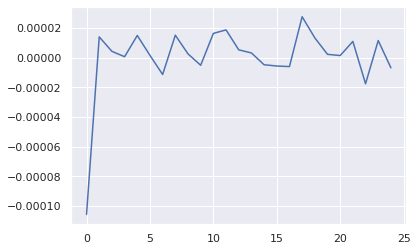